In [2]:
from vista_ssm import vista_ssm_Funcs as vista
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=600
import numpy as np
import pandas as pd
import random

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
dfo= pd.read_csv('../data/clean_ema.csv')
dfo = dfo.sort_values(['ID','Day','beepvar'])

dfo.rename(columns={"Q1": "Relax"} , inplace=True)
dfo.rename(columns={"Q2": "Irritable"} , inplace=True)
dfo.rename(columns={"Q3": "Worry"} , inplace=True)
dfo.rename(columns={"Q4": "Nervous"} , inplace=True)
dfo.rename(columns={"Q5": "Future"} , inplace=True)

dfo.rename(columns={"Q6": "Anhedonia"} , inplace=True)
dfo.rename(columns={"Q7": "Tired"} , inplace=True)
dfo.rename(columns={"Q8": "Hungry"} , inplace=True)
dfo.rename(columns={"Q9": "Alone"} , inplace=True)
dfo.rename(columns={"Q10": "Angry"} , inplace=True)

dfo.rename(columns={"Q11": "Social-offline"} , inplace=True)
dfo.rename(columns={"Q12": "Social-online"} , inplace=True)
dfo.rename(columns={"Q13": "Music"} , inplace=True)
dfo.rename(columns={"Q14": "Procrastinate"} , inplace=True)
dfo.rename(columns={"Q15": "Outdoors"} , inplace=True)

dfo.rename(columns={"Q16": "C19-occupied"} , inplace=True)
dfo.rename(columns={"Q17": "C19-worry"} , inplace=True)
dfo.rename(columns={"Q18": "Home"} , inplace=True)

dfo.drop(columns=["Music","Procrastinate","Hungry","Angry"],inplace=True)
features=dfo.columns[5:13] #19 originally
dfo.dropna(subset=features,inplace=True)

dates=pd.to_datetime(dfo['Response'].str[:19])
dfo['Response']=(dates-dates.min()).dt.total_seconds()/(3600*24)

users=np.array(list(dfo['ID'].unique()))

turns=[len(dfo[dfo['ID']==u]) for u in users]
users=[users[i] for i in range(len(users)) if turns[i]>33]

ema_data=[]
ema_time=[]
for k in range(len(users)):
    user_data=dfo[dfo['ID']==users[k]][features].to_numpy()
    user_data=user_data/5 #rescaling to 0-1
    user_data=user_data.reshape(len(user_data),len(features),1)
    ema_data.append(user_data)

    user_time=dfo[dfo['ID']==users[k]]['Response'].to_numpy()
    user_time -= min(user_time)
    ema_time.append(user_time)

ema_data=np.array(ema_data,dtype=object)
ema_time=np.array(ema_time,dtype=object)
tp=ema_time/max([np.max(row) for row in ema_time])

In [ ]:
for i in range(10):
    for nc in [2]:
        for dx in range(8,17):
            param_dic={'DIM_X': dx,
               'DIM_Y': len(features),
               'NUM_DATA': ema_data.shape[0],
               'N_CLUSTER' : nc,
               'NUM_CPU' : 30,
               'FIX' : [],
               'NUM_LGSSM' : 30,
               'MAX_ITER' : 1000,
               'EPSILON' : 0.1,
               'BIC' : True}

            result=vista.runVISTA('kmeans',param_dic,ema_data,tp)
            vista.savedic(result,'../results/ema/ema_kmeans_'+str(nc)+'_cluster_'+str(dx)+'_latent_'+str(i)+'.pickle')

In [5]:
# ### DASS-21 subscales 
# dep1 <- c(3, 5, 10, 13, 16, 17, 21)+13   # depression time 1
# dep2 <- c(3, 5, 10, 13, 16, 17, 21)+209  # depression time 2
# anx1 <- c(2, 4, 7, 9, 15, 19, 20)+13     # anxiety time 1
# anx2 <- c(2, 4, 7, 9, 15, 19, 20)+209    # anxiety time 2
# str1 <- c(1, 6, 8, 11, 12, 14, 18)+13    # stress time 1
# str2 <- c(1, 6, 8, 11, 12, 14, 18)+209   # stress time 2

def dass(x):
   # print(x)
    print(f'{np.mean(x):.2f} ({np.std(x):.2f})')
    x=2*np.array(x)
    print(f'Normal: {len(x[(x<10)])}')
    print(f'Mild: {len(x[(x>9)&(x<14)])}')
    print(f'Moderate: {len(x[(x>13)&(x<21)])}')
    print(f'Severe: {len(x[(x>20)&(x<28)])}')
    print(f'Extremely Severe: {len(x[(x>27)])}')
    return np.array([0 if (y<10) else 1 if ((y>9)&(y<14)) else 2 if ((y>13)&(y<21)) else 3 if ((y>20)&(y<28)) else 4 for y in x])

pp = pd.read_csv("../data/clean_prepost.csv") 
pp = pp.sort_values(['ID'])
pp = pp[pp['ID'].isin(users)]

dass_pre=pp[pp.columns[13:34]]-1
dass_pre_total=dass_pre[np.array(dass_pre.columns)[[2,4,9,12,15,16,20]]].to_numpy()
dass_pre_total=np.sum(dass_pre_total,axis=1).astype('float64')
print('Pre Assessment')
dass(dass_pre_total)
print('\n')
dass_post=pp[pp.columns[209:230]]-1
dass_post_total=dass_post[np.array(dass_post.columns)[[2,4,9,12,15,16,20]]].fillna(0).to_numpy()
dass_post_total=np.sum(dass_post_total,axis=1)
print('Post Assessment')
dass(dass_post_total)

dprb=np.where((2*dass_pre_total)>9,1,0)
dpob=np.where((2*dass_post_total)>9,1,0)

Pre Assessment
4.35 (3.80)
Normal: 46
Mild: 9
Moderate: 15
Severe: 2
Extremely Severe: 2


Post Assessment
5.36 (4.27)
Normal: 37
Mild: 10
Moderate: 16
Severe: 6
Extremely Severe: 5


In [13]:
vista.agg_perf('../results/ema/ema_kmeans_',[2],list(range(8,17)),10,criteria=[1],std=[True,True],label=dpob)

Information Criteria:

ABIC:
                      2
8   -4.22E+04 (1143.79)
9    -4.32E+04 (462.30)
10   -4.37E+04 (603.63)
11   -4.39E+04 (556.05)
12   -4.37E+04 (591.24)
13   -4.40E+04 (712.57)
14   -4.42E+04 (673.12)
15  -4.32E+04 (1766.26)
16   -4.38E+04 (975.36)

Cluster Similarity:
              2
8   0.74 (0.01)
9   0.74 (0.01)
10  0.75 (0.01)
11  0.74 (0.01)
12  0.74 (0.02)
13  0.74 (0.01)
14  0.74 (0.01)
15  0.72 (0.05)
16  0.74 (0.01)

Adjusted Rand Index:
              2
8   0.22 (0.02)
9   0.22 (0.02)
10  0.24 (0.03)
11  0.22 (0.02)
12  0.23 (0.04)
13  0.22 (0.02)
14  0.22 (0.02)
15  0.20 (0.06)
16  0.22 (0.02)


In [7]:
def predicted_trajectories(params,data,label,T,num_sam=3,legend=False,xplot=[0,1],plotcolor=(plt.cm.rainbow,0,1,1),T_final=1,**kwargs):

    dy=len(params['Sigma'][0])
    nc=len(params['weight'])
    n=len(data)
    if kwargs:
        if 'features' in kwargs:
            features=kwargs['features']
        else:
            features=['Feature '+str(i) for i in range(dy)]
        if 'row_labels' in kwargs:
            row_labels=kwargs['row_labels']
        else:
            row_labels=['Series '+str(i) for i in range(n)]
        if 'true' in kwargs:
            true_params=kwargs['true']
            true_X=noiseless_trajectory(true_params,T)
    else:
        features=['Feature '+str(i) for i in range(dy)]
     

    sim_X=vista.noiseless_trajectory(params,T,T_final)
    
    num_sam_list=[min(num_sam,list(label).count(k)) for k in range(nc)]
    
    real_ind=[random.sample(list(np.arange(0,len(data),1)[np.where(label==k)]),num_sam_list[k]) for k in range(nc)]
    
    fig = plt.figure(figsize=(15,3*dy))
    for i in range(1):
        for k in range(nc):
            ax=fig.add_subplot(dy,nc,nc*i+k+1)
            for l in range(num_sam_list[k]):
                X=data[real_ind[k][l]]
                if legend:
                    ax.plot(np.linspace(xplot[0],xplot[1],len(X[:,i])),ftgrp(X,i),label=row_labels[real_ind[k][l]],alpha=plotcolor[3])
                else:
                    ax.plot(np.linspace(xplot[0],xplot[1],len(X[:,i])),ftgrp(X,i),label='_nolegend_',alpha=plotcolor[3])
            for l,j in enumerate(ax.lines):
                colormap = plotcolor[0]
                colors = [colormap(i) for i in np.linspace(plotcolor[1], plotcolor[2], len(ax.lines))]
                j.set_color(colors[l])
            ax.plot(np.linspace(xplot[0],xplot[1],len(sim_X[k][:,i])),ftgrp(sim_X[k],i),'r--',label='Predicted Trajectory',linewidth=2)
            if 'true' in kwargs:
                ax.plot(np.linspace(xplot[0],xplot[1],len(true_X[k][:,i])),ftgrp(true_X[k],i),'k--',label='True Trajectory',linewidth=2)
            ax.legend()
            if 'ylim' in kwargs:
                ax.set_ylim(kwargs['ylim'])
            ax.set_title(f'Aggregated Mental Health Items, Cluster {k}')
    plt.show()

def ftgrp(X,i):
    if i==0:
        return np.sum(X[:,:8],axis=1)
    else:
        return np.sum(X[:,8:],axis=1)

confusion matrix
[[27 10]
 [ 7 30]]
Accuracy :  0.7702702702702703
Adjusted Rand Index :  0.28241881980583705
ROC AUC:  0.7702702702702703


              precision    recall  f1-score   support

           0       0.79      0.73      0.76        37
           1       0.75      0.81      0.78        37

    accuracy                           0.77        74
   macro avg       0.77      0.77      0.77        74
weighted avg       0.77      0.77      0.77        74



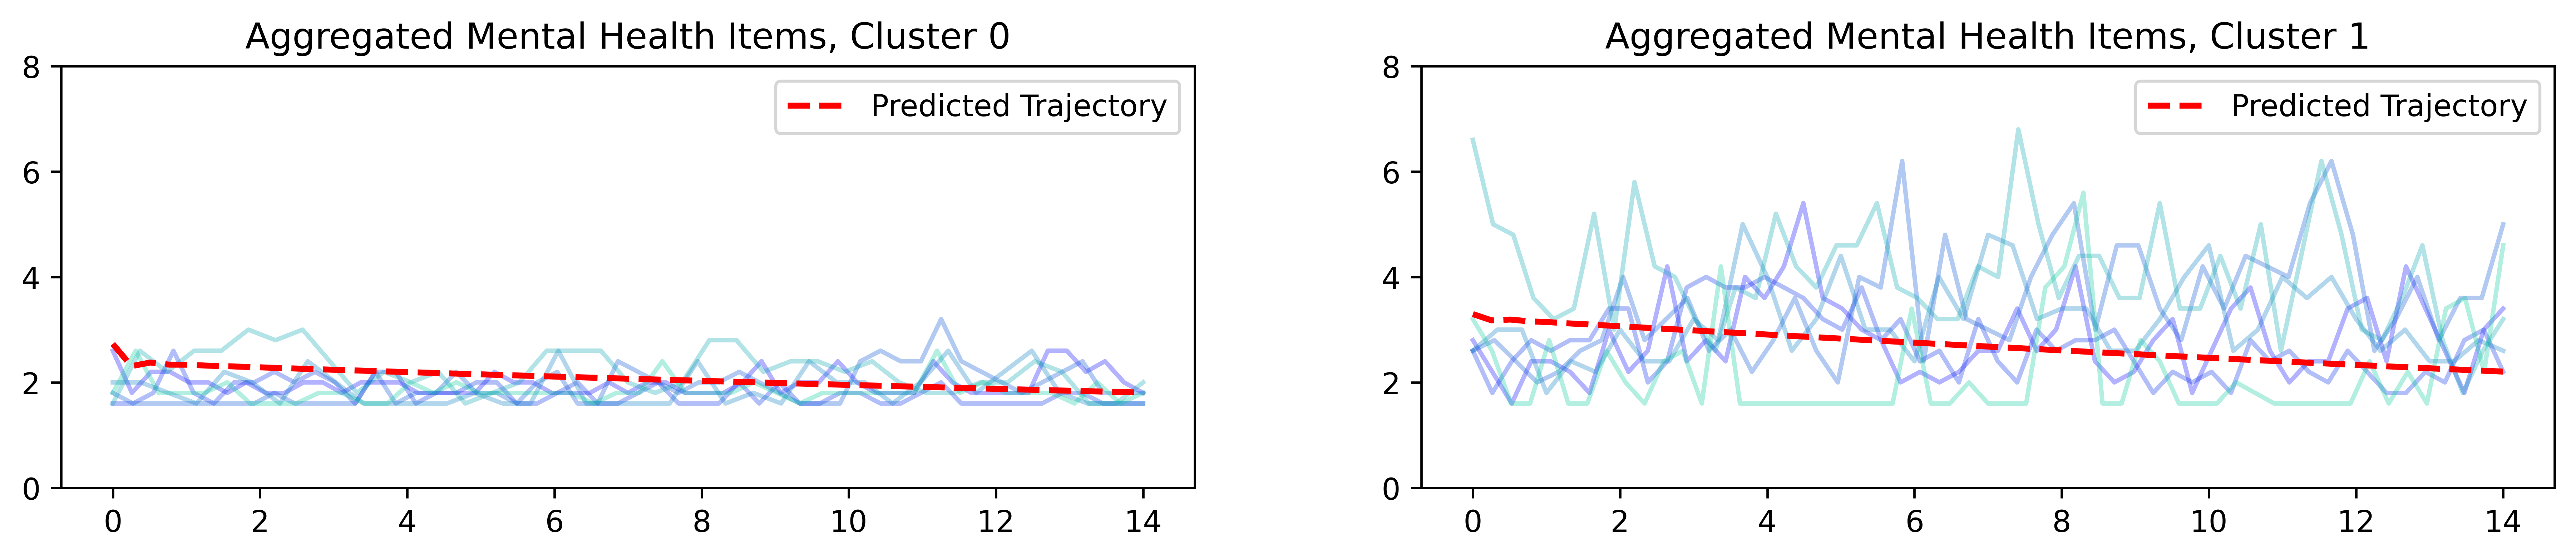

In [12]:
lbl=dpob
nc=2
result=vista.loaddic('../results/ema/ema_kmeans_2_cluster_10_latent_4.pickle')
vista.summarystats(lbl,result['label'],nc)
result_permuted=vista.best_perm(lbl,result['label'],nc,result['parameter'])
predicted_trajectories(result_permuted['parameter'],ema_data,result_permuted['label'],56,T_final=1,
                              num_sam=6,legend=False,features=features,plotcolor=(plt.cm.winter,0,0.8,0.3),ylim=[0,8],xplot=[0,14],timepoints=tp)